#### What we're going to cover

- Getting a vision dataset to work with using `torchvision.datasets`
- Architecture of a `Convolutional Neural Network` (CNN) with PyTorch
- An end-to-end multi-class image classification problem
- Steps in modelling with CNNs in PyTorch:
    - Creating a CNN model with PyTorch
    - Picking a loss and optimizer
    - Training the model
    - Evaluating the model
    - Saving and loading the model

#### What is a Convolutional Neural Network (CNN)?

- research the topic

![Screenshot from 2024-06-28 15-49-19.png](<attachment:Screenshot from 2024-06-28 15-49-19.png>)

#### Computer vision libraries

- Torchvision is a popular library for computer vision, it contains many datasets and models to use with PyTorch.
- `torchvision.datasets` get datasets and data loading functions for computer vision.
- `torchvision.models` get pre-trained models for computer vision.
- `torchvision.transforms` functions for manipulating vision data (images) to be suitable for use with ML models.
- `torch.utils.data.Dataset` Base dataset class for PyTorch.
- `torch.utils.data.DataLoader` creates a python iterable over a dataset.
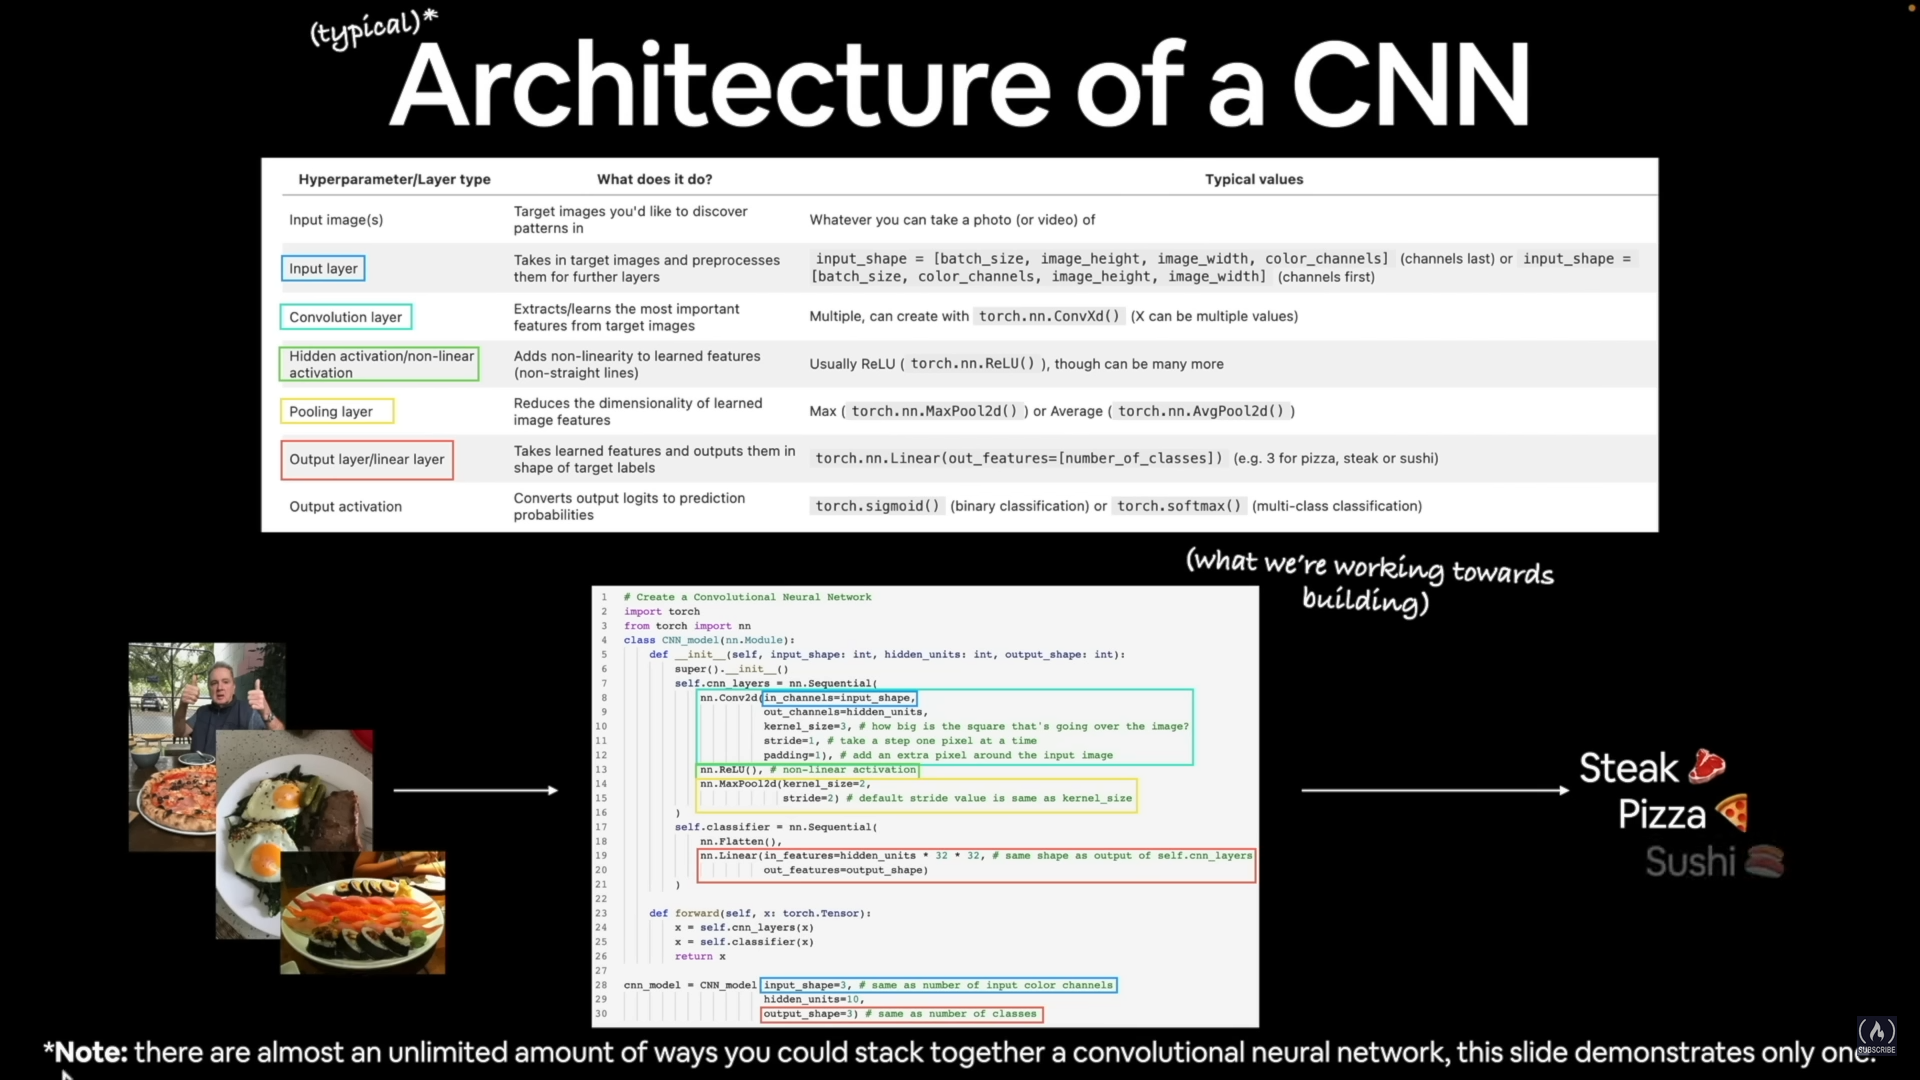

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=ToTensor(),
    target_transform=None # how do we want to transform the labels?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(training_data), len(test_data)

(60000, 10000)

In [4]:
image, label = training_data[0]
print(image.shape) # torch.FloatTensor (color channel, height, width)
print(label)

torch.Size([1, 28, 28])
9


In [5]:
class_to_idx = training_data.class_to_idx
class_names = training_data.classes
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

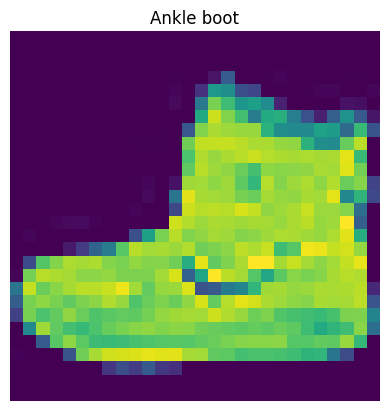

In [6]:
plt.title(class_names[label])
plt.axis(False)
plt.imshow(image.squeeze())

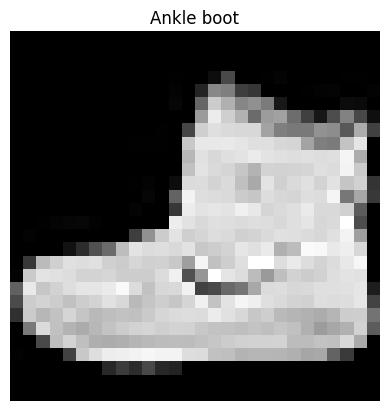

In [7]:
plt.title(class_names[label])
plt.axis(False)
plt.imshow(image.squeeze(), cmap="gray")

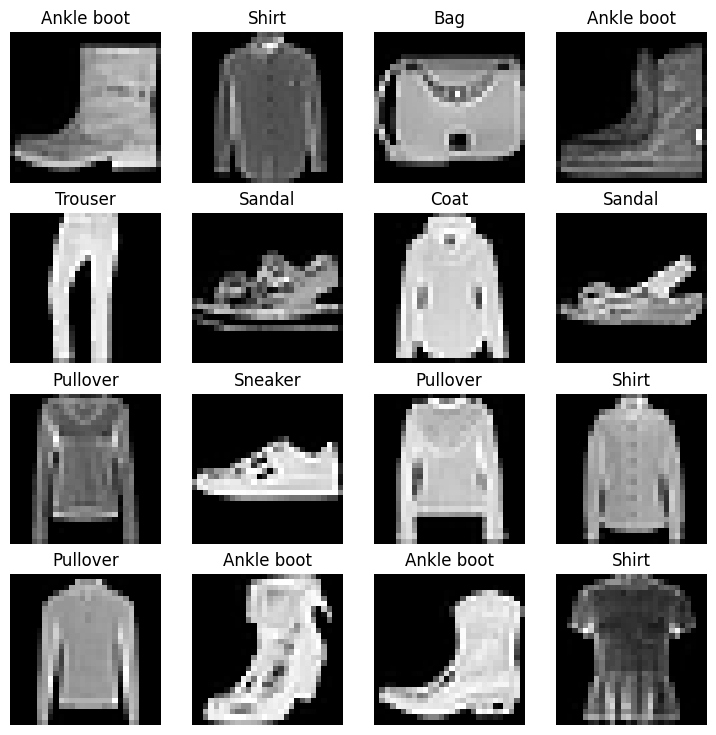

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(training_data), size=[1]).item()
    img, label = training_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

- Right now, our data is in the form of pyTorch Datasets
- Dataloader tuns our dataset into python iterable
- We want to turn it into batches (or mini-batches)

Why do we need batches?
    
1. It is more computationally efficient, as in, your computing hardware may not be able 
to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32) 

2. It gives our neural network more chances to update its gradients per epoch.

It's much better to have the batch consist of mixed up samples (shuffle) of our data (that means, our batch consists of shirts, sandals, and so on).

In [9]:
training_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

# in test data, its generally faster to not shuffle, plus, having mixed up batches won't add anything 
# to the training process
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(len(train_dataloader)) # 60000 / 32 = 1875
print(len(test_dataloader)) # 10000 / 32 = ceil(312.5) = 313

1875
313


In [12]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

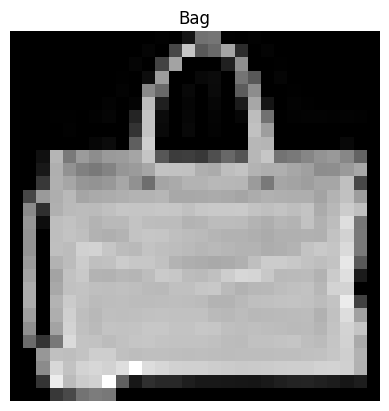

In [13]:
# show a sample

random_idx = torch.randint(0, len(train_feature_batch), size=[1]).item()
img, label = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

#### Model: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model. This will give you an idea of the quality of your model without needing to build anything

A baseline model is a sample model you will try and improve upon with subsequent models/experiments.
In other words, start simply and add more complexity when necessary.

In [14]:
# create a flatten layer
flatten_model = nn.Flatten(1, -1) # flatten all dimensions except the batch dimension

# Get a single sample
x = train_feature_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} - Shape after flattening: {output.shape}")
print("[color channel, height, width] -> [color channel, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) - Shape after flattening: torch.Size([1, 784])
[color channel, height, width] -> [color channel, height*width]


In [15]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into a single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units), # hidden layer
            nn.Linear(in_features=hidden_units, out_features=output_shape) # output layer
        )

    def forward(self, x):
        return self.layer_stack(x)

model_0 = FashionMNISTModelV0(
    input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.5382, -0.2103, -0.1958, -0.2007,  0.4601, -0.1884,  0.1586,  0.2547,
         -0.3227, -0.3623]], grad_fn=<AddmmBackward0>)

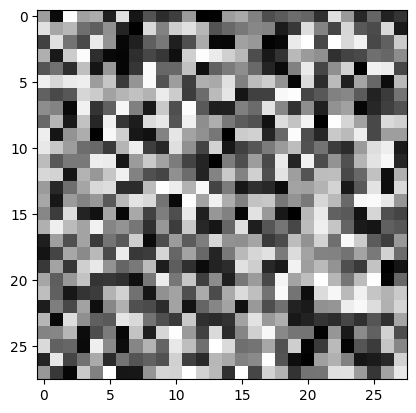

In [17]:
plt.imshow(dummy_x[0].squeeze(), cmap="gray")

In [18]:
# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # multi class classification -> use CrossEntropyLoss
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Evaluation metric - since we're working on a classification problem, we'll use accuracy
from helper_functions import accuracy_fn

